# Build GAN (Generative Adversarial Networks) with PyTorch and SageMaker

There are many public datasets on the Internet, which are very helpful for machine learning engineering and scientific research, such as algorithm study and evaluation. We will use MNIST dataset, which is a handwritten digits dataset, we will use it to train a GAN model, and eventually generate some fake "handwritten" digits.


### Environment setup
Upgrade packages

In [ ]:
!pip install --upgrade pip sagemaker awscli boto3 numpy ipywidgets
!pip install Pillow==7.1.2

Following commands for ```SageMaker Studio``` only

In [ ]:
!pip uninstall -y tqdm

Create folders

In [ ]:
!mkdir -p data src tmp

### Data preparation

PyTorch framework has a torchvision.datasets package, which provides MNIST dataset, you may use the following commands to download MNIST dataset to local storage, for late use.

When you get error message like below, please make sure you have tqdm package removed by running ```!pip uninstall -y tqdm```, and restart the kernel.
```
ImportError: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
```


In [ ]:
from torchvision import datasets

dataroot = './data'

trainset = datasets.MNIST(root=dataroot, train=True, download=True)
testset = datasets.MNIST(root=dataroot, train=False, download=True)

SageMaker SDK will create a default Amazon S3 bucket for you to access various files and data, that you may need in the machine learning engineering lifecycle. We can get the name of this bucket through the default_bucket method of the sagemaker.session.Session class in the SageMaker SDK.

In [ ]:
from sagemaker.session import Session

sess = Session()

# S3 bucket for saving code and model artifacts.
# Feel free to specify a different bucket here if you wish.
bucket = sess.default_bucket()
prefix = 'byos-pytorch-gan'

# Location to save your custom code in tar.gz format.
s3_custom_code_upload_location = f's3://{bucket}/{prefix}/customcode'

# Location where results of model training are saved.
s3_model_artifacts_location = f's3://{bucket}/{prefix}/artifacts/'

The SageMaker SDK provides tools for operating AWS services. For example, the S3Downloader class is used to download objects in S3, and the S3Uploader is used to upload local files to S3. You will upload the dataset files to Amazon S3 for model training. During model training, we do not download data from the Internet to avoid network latency caused by fetching data from the Internet, and at the same time avoiding possible security risks due to direct access to the Internet.


In [ ]:
import os
from sagemaker.s3 import S3Uploader as s3up

s3_data_location = s3up.upload(os.path.join(dataroot, "MNIST"), f"s3://{bucket}/{prefix}/data/mnist")

### Training




Generative Adversarial Network (GAN) is a generative machine learning model, which is widely used in advertising, games, entertainment, media, pharmaceuticals etc many industries. For example, it can be used to create fictional characters and scenes, simulate facial aging, change image styles, produce chemical formulas and so on.

GAN was proposed by Ian Goodfellow in 2014, it is a deep neural network architecture consisting of a generative network and a discriminant network. The generation network generates "fake" data and tries to deceive the discrimination network; the discrimination network authenticates the generated data and tries to correctly identify all "fake" data. In the process of training iterations, the two networks continue to evolve and confront until they reach an equilibrium state (reference: Nash equilibrium), the discriminant network can no longer recognize "fake" data, and the training ends.

DCGAN (Deep Convolutional Generative Adversarial Networks) is a variant of the GAN families. This architecture essentially leverages Deep Convolutional Neural Networks to generate images belonging to a given distribution from noisy data using the Generator-Discriminator framework.

In [ ]:
%%writefile src/train.py

from __future__ import print_function
import argparse
import json
import logging
import os
import sys
import random

import torch
import torch.nn as nn
import torch.nn.parallel
import torch.nn.functional as F

import torch.optim as optim
import torch.backends.cudnn as cudnn
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils


cudnn.benchmark = True

logger = logging.getLogger(__name__)
logger.setLevel(logging.DEBUG)
logger.addHandler(logging.StreamHandler(sys.stdout))


class Generator(nn.Module):
    def __init__(self, *, nz, nc, ngf, ngpu=1):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d(     nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d(ngf * 2,     ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d(    ngf,      nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )

    def forward(self, input):
        if input.is_cuda and self.ngpu > 1:
            output = nn.parallel.data_parallel(self.main, input, range(self.ngpu))
        else:
            output = self.main(input)
        return output

    def save(self, path, *, filename=None, device='cpu'):
        # recommended way from http://pytorch.org/docs/master/notes/serialization.html
        self.to(device)
        if not filename is None:
            path = os.path.join(path, filename)
        torch.save(self.state_dict(), path)

    def load(self, path, *, filename=None):
        if not filename is None:
            path = os.path.join(path, filename)
        with open(path, 'rb') as f:
            self.load_state_dict(torch.load(f))

    
class Discriminator(nn.Module):
    def __init__(self, *, nc, ndf, ngpu=1):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        if input.is_cuda and self.ngpu > 1:
            output = nn.parallel.data_parallel(self.main, input, range(self.ngpu))
        else:
            output = self.main(input)

        return output.view(-1, 1).squeeze(1)

    def save(self, path, *, filename=None, device='cpu'):
        # recommended way from http://pytorch.org/docs/master/notes/serialization.html
        self.to(device)
        if not filename is None:
            path = os.path.join(path, filename)
        torch.save(self.state_dict(), path)


    def load(self, path, *, filename=None):
        if not filename is None:
            path = os.path.join(path, filename)
        with open(path, 'rb') as f:
            self.load_state_dict(torch.load(f))
            
            
class DCGAN(object):
    """
    A wrapper class for Generator and Discriminator,
    'train_step' method is for single batch training.
    """

    fixed_noise = None
    criterion = None
    device = None
    netG = None
    netD = None
    optimizerG = None
    optimizerD = None
    nz = None
    nc = None
    ngf = None
    ndf = None
    real_cpu = None
    
    def __init__(self, *, batch_size, nz, nc, ngf, ndf, device, weights_init,
                    learning_rate, betas, real_label, fake_label):

        super(DCGAN, self).__init__()

        import torch
        
        self.nz = nz
        self.nc = nc
        self.ngf = ngf
        self.ndf = ndf
        
        self.real_label = real_label
        self.fake_label = fake_label
        
        self.fixed_noise = torch.randn(batch_size, nz, 1, 1, device=device)
        self.criterion = nn.BCELoss()
        self.device = device
        
        self.netG = Generator(nz=nz, nc=nc, ngf=ngf).to(device)
        # print(netG)
        self.netD = Discriminator(nc=nc, ndf=ndf).to(device)
        # print(netD)
        
        self.netG.apply(weights_init)
        self.netD.apply(weights_init)
        
        # setup optimizer
        self.optimizerG = optim.Adam(self.netG.parameters(), lr=learning_rate, betas=betas)
        self.optimizerD = optim.Adam(self.netD.parameters(), lr=learning_rate, betas=betas)


    def train_step(self, data, *, epoch, epochs):
        import torch

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        # train with real
        self.netD.zero_grad()
        self.real_cpu = data[0]
        real = data[0].to(self.device)
        batch_size = real.size(0)
        label = torch.full((batch_size,), self.real_label, device=self.device)
        
        output = self.netD(real).view(-1)
        errD_real = self.criterion(output, label)
        errD_real.backward()
        D_x = output.mean().item()


        # train with fake
        noise = torch.randn(batch_size, self.nz, 1, 1, device=self.device)
        fake = self.netG(noise)
        label.fill_(self.fake_label)
        output = self.netD(fake.detach()).view(-1)
        errD_fake = self.criterion(output, label)
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        errD = errD_real + errD_fake
        self.optimizerD.step()
    

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        self.netG.zero_grad()
        label.fill_(self.real_label)  # fake labels are real for generator cost
        output = self.netD(fake).view(-1)
        errG = self.criterion(output, label)
        errG.backward()
        D_G_z2 = output.mean().item()
        self.optimizerG.step()


        return errG.item(), errD.item(), D_x, D_G_z1, D_G_z2
                

        
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        torch.nn.init.normal_(m.weight, 1.0, 0.02)
        torch.nn.init.zeros_(m.bias)


def log_batch(epoch, epochs, batch, batches, errD, errG, D_x, D_G_z1, D_G_z2, *, log_interval=10, output_dir):

    if batch % log_interval == 0:
        logger.info(f"Epoch[{epoch}/{epochs}], Batch[{batch}/{batches}], " +
                    f"Loss_D: {errD:.4}, Loss_G: {errG:.4}, D(x): {D_x:.4}, D(G(z)): {D_G_z1:.4}/{D_G_z2:.4}")



def get_device(use_cuda):
    import torch

    device = "cpu"
    num_gpus = 0
        
    if torch.cuda.is_available():
        if use_cuda:
            device = "cuda"
            torch.cuda.set_device(0)
            num_gpus = torch.cuda.device_count()
        else:
            logger.debug("WARNING: You have a CUDA device, so you should probably run with --cuda 1")

    logger.debug(f"Number of gpus available: {num_gpus}")
    
    return device, num_gpus


def train(dataloader, hps, test_batch_size,
          device, model_dir, output_dir, seed, log_interval):
    
    epochs = hps['epochs']
    batch_size = hps['batch-size']
    nz = hps['nz']
    ngf = hps['ngf']
    ndf = hps['ndf']
    learning_rate = hps['learning-rate']
    beta1 = hps['beta1']
        
    dcgan = DCGAN(batch_size=batch_size, nz=nz, nc=1, ngf=ngf, ndf=ndf,
                    device=device, weights_init=weights_init, learning_rate=learning_rate,
                    betas=(beta1, 0.999), real_label=1, fake_label=0)

    for epoch in range(epochs):
        batches = len(dataloader)
        for batch, data in enumerate(dataloader, 0):
            errG, errD, D_x, D_G_z1, D_G_z2 = dcgan.train_step(data,
                          epoch=epoch, epochs=epochs)
        
            log_batch(epoch, epochs, batch, batches, errD, errG,
                            D_x, D_G_z1, D_G_z2, log_interval=log_interval, output_dir=output_dir)

        
    save_model(model_dir, dcgan.netG)

    return


def save_model(model_dir, model):
    logger.info("Saving the model.")
    model.save(model_dir, filename="model.pth")

    
def load_model(model_dir, device=None):
    logger.info("Loading the model.")
    if device is None:
        device = get_training_device_name(1)

    netG.load(model_dir, filename="model.pth", device=device)

    return netG


def parse_args():
    # Training settings
    parser = argparse.ArgumentParser(description='PyTorch Example')
    
    parser.add_argument('--batch-size', type=int, default=1000, metavar='N',
                        help='input batch size (default: 1000)')
    parser.add_argument('--test-batch-size', type=int, default=1000, metavar='N',
                        help='input batch size for testing (default: 1000)')
    parser.add_argument('--seed', type=int, default=None, metavar='S',
                        help='random seed')
    parser.add_argument('--log-interval', type=int, default=10, metavar='N',
                        help='how many batches to wait before logging training status')

    parser.add_argument('--save-model', action='store_true', default=False,
                        help='For Saving the current Model')

    parser.add_argument('--model-dir', type=str, default=os.environ.get('SM_MODEL_DIR', None))
    
    parser.add_argument('--cuda', type=int, default=1)
    parser.add_argument('--num-gpus', type=int, default=os.environ.get('SM_NUM_GPUS', None))
    
    parser.add_argument('--pin-memory', type=bool, default=os.environ.get('SM_PIN_MEMORY', False))

    parser.add_argument('--data-dir', required=False, default=None, help='path to data dir')
    parser.add_argument('--workers', type=int, help='number of data loading workers', default=2)
    parser.add_argument('--output-dir', default=os.environ.get('SM_OUTPUT_DATA_DIR', None), help='folder to output images and model checkpoints')
    parser.add_argument('--hps', default=os.environ.get('SM_HPS', None), help='Hyperparameters')
    
    return parser.parse_known_args()


def get_datasets(*, dataroot='/opt/ml/input/data', classes=None):

    dataset = dset.MNIST(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Resize(64),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5,), (0.5,)),
                           ]))

    return dataset
    

if __name__ == '__main__':
    args, unknown = parse_args()
    
    # get training options
    hps = json.loads(args.hps)

    try:
        os.makedirs(args.output_dir)
    except OSError:
        pass

    if args.seed is None:
        random_seed = random.randint(1, 10000)
        logger.debug(f"Generated Random Seed: {random_seed}")
        cudnn.benchmark = True
    else:
        logger.debug(f"Provided Random Seed: {args.seed}")
        random_seed = args.seed
        cudnn.deterministic = True
        cudnn.benchmark = False
        
    random.seed(random_seed)
    torch.manual_seed(random_seed)

    pin_memory=args.pin_memory
    num_workers = int(args.workers)
    
    device, num_gpus = get_device(args.cuda)
    
    if device == 'cuda':
        num_workers = 1
        pin_memory = True

    
    if args.data_dir is None:
        input_dir = os.environ.get('SM_INPUT_DIR', None)
        if input_dir is None and str(args.dataset).lower() != 'fake':
            raise ValueError(f"`--data-dir` parameter is required for dataset \"{args.dataset}\"")

        dataroot = input_dir + "/data"
    else:
        dataroot = args.data_dir

    dataset = get_datasets(dataroot=dataroot)

    assert dataset
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=args.batch_size,
                    shuffle=True, num_workers=num_workers, pin_memory=pin_memory)

    
    train(dataloader, hps, args.test_batch_size, device, args.model_dir, args.output_dir, args.seed, args.log_interval)

Per sagemaker.get_execution_role() method, the notebook can get the role pre-assigned to the notebook instance. This role will be used to obtain training resources, such as downloading training framework images, allocating Amazon EC2 instances, and so on.

In [ ]:
from sagemaker import get_execution_role

# IAM execution role that gives SageMaker access to resources in your AWS account.
# We can use the SageMaker Python SDK to get the role from our notebook environment. 
role = get_execution_role()

The hyperparameters, that used in the model training tasks, can be defined in the notebook so that it is separated from the algorithm and training code. The hyperparameters are passed in when the training task is created and dynamically combined with the training task.

In [82]:
import json

hps = {
         'seed': 0,
         'learning-rate': 0.0002,
         'epochs': 18,
         'pin-memory': 1,
         'beta1': 0.5,
         'nz': 100,
         'ngf': 28,
         'ndf': 28,
         'batch-size': 128,
         'log-interval': 20,
     }


str_hps = json.dumps(hps, indent = 4)
print(str_hps)

{
    "seed": 0,
    "learning-rate": 0.0002,
    "epochs": 18,
    "pin-memory": 1,
    "beta1": 0.5,
    "nz": 100,
    "ngf": 28,
    "ndf": 28,
    "batch-size": 128,
    "log-interval": 20
}


```PyTorch``` class from sagemaker.pytorch package, is an estimator for PyTorch framework, it can be used to create and execute training tasks, as well as to deploy trained models. In the parameter list, ``train_instance_type`` is used to specify the instance type, such as CPU or GPU instances. The directory containing training script and the model code are specified by ``source_dir``, and the training script file name must be clearly defined by ``entry_point``. These parameters will be passed to the training task along with other parameters, and they determine the environment settings of the training task.

In [ ]:
from sagemaker.pytorch import PyTorch

estimator = PyTorch(role=role,
                        entry_point='train.py',
                        source_dir='./src',
                        output_path=s3_model_artifacts_location,
                        code_location=s3_custom_code_upload_location,
                        instance_count=1,
                        instance_type='ml.g4dn.2xlarge',
#                         use_spot_instances=True,
#                         max_wait=3600,
#                         max_run=1800,
                        framework_version='1.5.0',
                        py_version='py3',
                        hyperparameters=hps,
                   )

Please pay special attention to the ``train_use_spot_instances`` parameter. The value of ``True`` means that you want to use SPOT instances first. Since machine learning training usually requires a large amount of computing resources to run for a long time, leveraging SPOT instances can help you control your cost. The SPOT instances may save cost up to 90% of the on-demand instances, depending on the instance type, region, and time, the actual price might be different.

You have created a PyTorch object, and you can use it to fit pre-uploaded data on Amazon S3. The following command will initiate the training task, and the training data will be imported into the training environment in the form of an input channel named **MNIST**. When the training task starts, the training data was already downloaded from S3 to the local file system of the training instance, and the training script ```train.py``` will load the data from the local disk afterwards.

In [ ]:
# Start training
estimator.fit({"MNIST": s3_data_location}, wait=False)

Depending on the training instance you choose, the training process may last from tens of minutes to several hours. It is recommended to set the ``wait`` parameter to ``False``, this option will detach the notebook from the training task. In scenarios with long training time and many training logs, it can prevent the notebook context from being lost due to network interruption or session timeout. After the notebook detached from the training task, the output will be temporarily invisible. You can execute the following code, and the notebook will obtain and resume the previous training session.

In [ ]:
%%time
from sagemaker.estimator import Estimator

# Attaching previous training session
training_job_name = estimator.latest_training_job.name
attached_estimator = Estimator.attach(training_job_name)


2021-09-30 01:20:39 Starting - Starting the training job
2021-09-30 01:20:40 Starting - Launching requested ML instances.............
2021-09-30 01:21:54 Starting - Preparing the instances for training..................................

Since the model was designed to leverage the GPU power to accelerate training, it will be much faster than training tasks on CPU instances. For example, the p3.2xlarge instance will take about 15 minutes, while the c5.xlarge instance may take more than 6 hours. The current model does not support distributed and parallel training, so multi-instance and multi-CPU/GPU will not bring extra benefits in training speed boosting.

When the training completes, the trained model will be uploaded to S3. The upload location is specified by the `output_path` parameter provided when creating the `PyTorch` object.

### Model verification

You will download the trained model from Amazon S3 to the local file system of the instance where the notebook is located. The following code will load the model, and then generate a picture with a random number as input, then display picture.


In [ ]:
from sagemaker.s3 import S3Downloader as s3down

!mkdir -p ./tmp

model_url = attached_estimator.model_data
s3down.download(model_url, './tmp')

In [ ]:
!tar -zxf tmp/model.tar.gz -C ./tmp

Execute the following instructions to load the trained model, and generate a set of "handwritten" digitals.

In [ ]:
def generate_fake_handwriting(model, *, num_images, nz, device=None):

    import torch
    import torchvision.utils as vutils
    from io import BytesIO
    from PIL import Image
    

    z = torch.randn(num_images, nz, 1, 1, device=device)
    fake = model(z)

    imgio = BytesIO()
    vutils.save_image(fake.detach(), imgio, normalize=True, format="PNG")
    img = Image.open(imgio)
    
    return img


def load_model(path, *, model_cls=None, params=None, filename=None, device=None, strict=True):

    import os
    import torch
    
    model_pt_path = path
    if not filename is None:
        model_pt_path = os.path.join(path, filename)
        
    if device is None:
        device = 'cpu'
        
    if not model_cls is None:
        model = model_cls(**params)
        model.load_state_dict(torch.load(model_pt_path, map_location=torch.device(device)), strict=strict)
    else:
        model = torch.jit.load(model_pt_path, map_location=torch.device(device))

    model.to(device)
    
    return model



[2021-09-29 23:45:41.647 pytorch-1-6-gpu-py3-ml-g4dn-xlarge-594def216eaae0b31fbf025840e5:234 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2021-09-29 23:45:41.671 pytorch-1-6-gpu-py3-ml-g4dn-xlarge-594def216eaae0b31fbf025840e5:234 INFO profiler_config_parser.py:102] Unable to find config at /opt/ml/input/config/profilerconfig.json. Profiler is disabled.


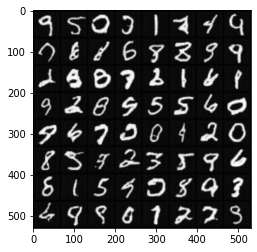

In [50]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from src.train import Generator

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

params = {'nz': hps['nz'], 'nc': 1, 'ngf': hps['ngf']}
model = load_model("./tmp/model.pth", model_cls=Generator, params=params, device=device, strict=False)
img = generate_fake_handwriting(model, num_images=64, nz=hps['nz'], device=device)

plt.imshow(np.asarray(img))